In [1]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
import pandas as pd

In [7]:
# Load the metadata
metadata_path = "C:\\Users\\ASUS\\Desktop\\ML project\\train-metadata.csv"  # Replace with the actual path
metadata = pd.read_csv(metadata_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21056\3796003563.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)


In [9]:
# Verify the dataset structure
print(metadata.head())
print(metadata['target'].value_counts())  # Ensure target column is correctly loaded

        isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

    lesion_id  iddx_full  iddx_1  iddx_2  iddx_3  iddx_4  iddx

In [11]:
# Separate majority and minority classes
majority = metadata[metadata['target'] == 0]
minority = metadata[metadata['target'] == 1]

print(f"Majority class size: {len(majority)}")
print(f"Minority class size: {len(minority)}")


Majority class size: 400666
Minority class size: 393


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import os

def load_images(image_ids, folder, target_size=(224, 224)):
    images = []
    for image_id in image_ids:
        image_path = os.path.join(folder, f"{image_id}.jpg")  # Adjust file extension if necessary
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

# Load minority class images
minority_images = load_images(minority['isic_id'], "C:\\Users\\ASUS\\Desktop\\ML project\\image")


In [20]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a folder to save augmented images
augmented_folder = "C:\\Users\\ASUS\\Desktop\\ML project\\augmented_images"
os.makedirs(augmented_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment and save minority class images
num_augments = len(majority) - len(minority)  # Target number of augmented samples
image_counter = 0  # Counter for naming augmented images

for img, img_id in zip(minority_images, minority['isic_id']):
    img = img.reshape((1,) + img.shape)  # Reshape for the generator
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_folder, save_prefix=f"{img_id}_aug", save_format="jpg"):
        i += 1
        image_counter += 1
        if i >= num_augments // len(minority_images):  # Generate required number of augmentations
            break

print(f"Saved {image_counter} augmented images to {augmented_folder}")


KeyboardInterrupt: 

In [15]:
# Sample 50K from the majority class
majority_50k = majority.sample(n=50000, random_state=42)  # `majority` is the DataFrame for target=0

In [17]:
import os
import pandas as pd

# List all augmented images
augmented_images = os.listdir("C:\\Users\\ASUS\\Desktop\\ML project\\augmented_images")
augmented_image_ids = [os.path.splitext(f)[0] for f in augmented_images]  # Remove file extensions

# Create metadata for augmented images
augmented_metadata = pd.DataFrame({'isic_id': augmented_image_ids, 'target': 1})

# Sample 50K augmented images
augmented_50k = augmented_metadata.sample(n=50000, random_state=42)


In [18]:
# Combine original majority and augmented minority data
balanced_metadata = pd.concat([majority_50k, augmented_50k]).reset_index(drop=True)

# Shuffle the dataset
balanced_metadata = balanced_metadata.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify class distribution
print("Balanced Dataset Class Distribution:")
print(balanced_metadata['target'].value_counts())


Balanced Dataset Class Distribution:
target
1    50000
0    50000
Name: count, dtype: int64


In [21]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os

# Paths to the original and augmented image folders
original_folder = "C:\\Users\\ASUS\\Desktop\\ML project\\image"  # Folder for original images
augmented_folder = "C:\\Users\\ASUS\\Desktop\\ML project\\augmented_images"  # Folder for augmented images


# Create a combined folder path metadata column
balanced_metadata['image_path'] = balanced_metadata['isic_id'].apply(
    lambda x: os.path.join(original_folder, f"{x}.jpg") if os.path.exists(os.path.join(original_folder, f"{x}.jpg"))
    else os.path.join(augmented_folder, f"{x}.jpg")
)

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the dataset
def data_generator(metadata, datagen, batch_size=32, target_size=(224, 224)):
    while True:
        for i in range(0, len(metadata), batch_size):
            batch = metadata.iloc[i:i + batch_size]
            images = []
            labels = []
            for _, row in batch.iterrows():
                if os.path.exists(row['image_path']):
                    img = load_img(row['image_path'], target_size=target_size)
                    img_array = img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(row['target'])
            yield np.array(images), np.array(labels)

# Initialize train generator
train_generator = data_generator(balanced_metadata, datagen, batch_size=32)

# Example: Load a batch
images, labels = next(train_generator)
print(f"Loaded a batch of {len(images)} images.")


Loaded a batch of 32 images.


In [23]:
from sklearn.model_selection import train_test_split

# Split combined metadata into train, validation, and test sets
train_metadata, temp_metadata = train_test_split(
    balanced_metadata, test_size=0.3, stratify=balanced_metadata['target'], random_state=42
)

val_metadata, test_metadata = train_test_split(
    temp_metadata, test_size=0.5, stratify=temp_metadata['target'], random_state=42
)

print(f"Train set: {len(train_metadata)}")
print(f"Validation set: {len(val_metadata)}")
print(f"Test set: {len(test_metadata)}")


Train set: 70000
Validation set: 15000
Test set: 15000


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for rescaling pixel values
datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]

# Define the batch size
batch_size = 32

# Define a generator function
def data_generator(metadata, datagen, batch_size=32, target_size=(224, 224)):
    """
    Generator for loading images in batches during training and validation.
    """
    while True:
        for i in range(0, len(metadata), batch_size):
            batch = metadata.iloc[i:i + batch_size]  # Select a batch of metadata
            images = []
            labels = []
            for _, row in batch.iterrows():
                image_path = row['image_path']  # Precomputed file paths
                if os.path.exists(image_path):
                    img = load_img(image_path, target_size=target_size)
                    img_array = img_to_array(img) / 255.0  # Normalize pixel values
                    images.append(img_array)
                    labels.append(row['target'])
            yield np.array(images), np.array(labels)


In [27]:
# Define the generators
train_generator = data_generator(train_metadata, datagen, batch_size=batch_size)
val_generator = data_generator(val_metadata, datagen, batch_size=batch_size)

In [29]:
from sklearn.model_selection import train_test_split

# Split balanced_metadata into training and validation sets
train_metadata, val_metadata = train_test_split(
    balanced_metadata, 
    test_size=0.2, 
    stratify=balanced_metadata['target'], 
    random_state=42
)

print(f"Training set size: {len(train_metadata)}")
print(f"Validation set size: {len(val_metadata)}")


Training set size: 80000
Validation set size: 20000


In [31]:
# Define batch size
batch_size = 32

# Steps per epoch for training and validation
steps_per_epoch = len(train_metadata) // batch_size
validation_steps = len(val_metadata) // batch_size

print(f"Steps per epoch (training): {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch (training): 2500
Validation steps: 625


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn_model.summary()


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=10  # Adjust as needed
)

print("Model training completed!")


In [38]:
cnn_model.save("cnn_model.h5")
print("Model saved successfully!")

Model saved successfully!


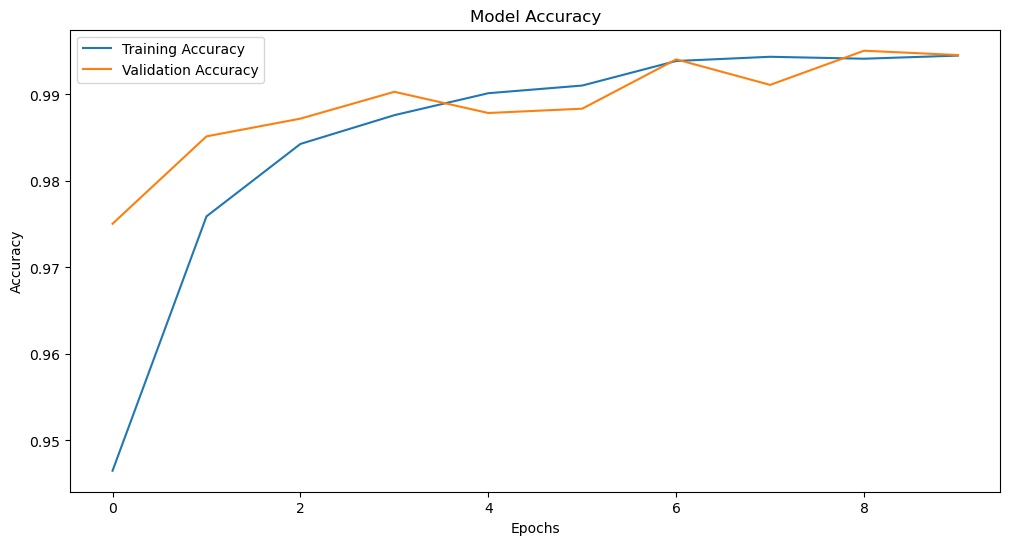

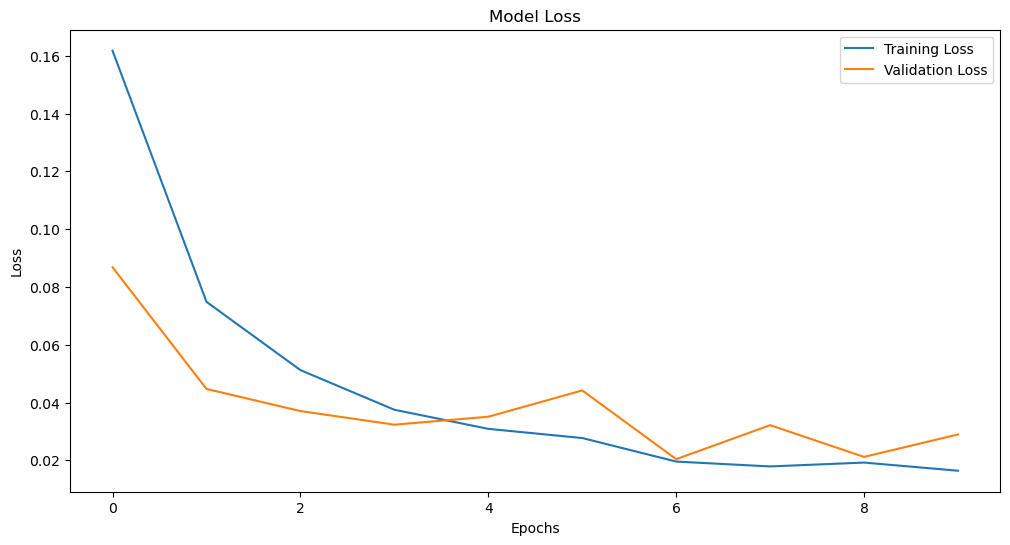

In [40]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [44]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("cnn_model.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [48]:
# Combine training and validation IDs
used_ids = set(train_metadata['isic_id']).union(set(val_metadata['isic_id']))

# Verify the size of the used IDs
print(f"Number of used IDs (training + validation): {len(used_ids)}")

Number of used IDs (training + validation): 100000


In [50]:
# Exclude training and validation IDs from the majority class
remaining_majority = majority[~majority['isic_id'].isin(used_ids)]

# Sample 50K unique images for testing
test_majority_50k = remaining_majority.sample(n=50000, random_state=123)

print(f"Remaining majority images after filtering: {len(remaining_majority)}")

Remaining majority images after filtering: 350666


In [53]:
# Exclude training and validation IDs from the augmented images
remaining_augmented = augmented_metadata[~augmented_metadata['isic_id'].isin(used_ids)]

# Sample 50K unique augmented images for testing
test_minority_50k = remaining_augmented.sample(n=50000, random_state=123)

print(f"Remaining augmented images after filtering: {len(remaining_augmented)}")


Remaining augmented images after filtering: 330205


In [55]:
# Combine majority and minority samples for the test dataset
test_metadata = pd.concat([test_majority_50k, test_minority_50k]).reset_index(drop=True)

# Shuffle the test dataset
test_metadata = test_metadata.sample(frac=1, random_state=123).reset_index(drop=True)

# Verify the class distribution
print("Test Dataset Class Distribution:")
print(test_metadata['target'].value_counts())


Test Dataset Class Distribution:
target
0    50000
1    50000
Name: count, dtype: int64


In [57]:
# Verify no overlap
overlap = set(test_metadata['isic_id']).intersection(used_ids)
print(f"Number of overlapping IDs between test and train/validation: {len(overlap)}")
assert len(overlap) == 0, "Overlap detected between test and training/validation sets!"


Number of overlapping IDs between test and train/validation: 0


In [230]:
# Add image paths to the test metadata
test_metadata['image_path'] = test_metadata['isic_id'].apply(
    lambda x: os.path.join(original_folder, f"{x}.jpg") if os.path.exists(os.path.join(original_folder, f"{x}.jpg"))
    else os.path.join(augmented_folder, f"{x}.jpg")
)

# Define the test generator
test_generator = data_generator(test_metadata, datagen, batch_size=32)
test_steps = len(test_metadata) // 32

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 824s 264ms/step - accuracy: 0.9939 - loss: 0.0300
Test Loss: 0.0296
Test Accuracy: 0.9941


In [ ]:
cnn_model.save("final_cnn_model.h5")
print("Final model saved successfully!")

## XGBoosting gradient boosting

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb

# Use the cleaned and balanced metadata
balanced_metadata = balanced_metadata.copy()

# Drop unnecessary columns and ensure no objects exist
columns_to_drop = ['isic_id', 'patient_id', 'image_path', 'attribution', 
                   'copyright_license', 'lesion_id', 'iddx_full', 'iddx_2', 
                   'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index']
metadata_features = balanced_metadata.drop(columns=columns_to_drop + ['target'], errors='ignore')

# Handle any remaining missing values
metadata_features = metadata_features.fillna(0)

# Target variable
y = balanced_metadata['target']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(metadata_features, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (70000, 43)
Validation set: (15000, 43)
Test set: (15000, 43)


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb

# Make a copy of the cleaned and preprocessed metadata
cleaned_metadata = balanced_metadata.copy()

# Drop unnecessary columns
columns_to_drop = ['isic_id', 'patient_id', 'attribution', 'copyright_license', 'lesion_id',
                   'iddx_full', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'image_path']
metadata = cleaned_metadata.drop(columns=columns_to_drop, errors='ignore')

# Handle categorical variables with one-hot encoding
categorical_columns = ['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type', 'tbp_lv_location', 
                       'tbp_lv_location_simple', 'iddx_1']
metadata = pd.get_dummies(metadata, columns=categorical_columns, drop_first=True)

# Ensure no missing values
metadata = metadata.fillna(0)

In [53]:
# Extract features and target
X = metadata.drop(columns=['target'])
y = metadata['target']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (70000, 70)
Validation set: (15000, 70)
Test set: (15000, 70)


In [55]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

# Train the model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Predict and evaluate on the test set
y_pred = xgb_model.predict(X_test)

[0]	validation_0-logloss:0.59815
[1]	validation_0-logloss:0.52035
[2]	validation_0-logloss:0.45547
[3]	validation_0-logloss:0.40063
[4]	validation_0-logloss:0.35378
[5]	validation_0-logloss:0.31343
[6]	validation_0-logloss:0.27843
[7]	validation_0-logloss:0.24790
[8]	validation_0-logloss:0.22114
[9]	validation_0-logloss:0.19760
[10]	validation_0-logloss:0.17683
[11]	validation_0-logloss:0.15843
[12]	validation_0-logloss:0.14210
[13]	validation_0-logloss:0.12758
[14]	validation_0-logloss:0.11464
[15]	validation_0-logloss:0.10309
[16]	validation_0-logloss:0.09276
[17]	validation_0-logloss:0.08351
[18]	validation_0-logloss:0.07523


C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:25:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.06780
[20]	validation_0-logloss:0.06113
[21]	validation_0-logloss:0.05514
[22]	validation_0-logloss:0.04975
[23]	validation_0-logloss:0.04490
[24]	validation_0-logloss:0.04053
[25]	validation_0-logloss:0.03660
[26]	validation_0-logloss:0.03306
[27]	validation_0-logloss:0.02986
[28]	validation_0-logloss:0.02698
[29]	validation_0-logloss:0.02438
[30]	validation_0-logloss:0.02204
[31]	validation_0-logloss:0.01992
[32]	validation_0-logloss:0.01801
[33]	validation_0-logloss:0.01628
[34]	validation_0-logloss:0.01473
[35]	validation_0-logloss:0.01332
[36]	validation_0-logloss:0.01205
[37]	validation_0-logloss:0.01090
[38]	validation_0-logloss:0.00986
[39]	validation_0-logloss:0.00892
[40]	validation_0-logloss:0.00807
[41]	validation_0-logloss:0.00730
[42]	validation_0-logloss:0.00661
[43]	validation_0-logloss:0.00598
[44]	validation_0-logloss:0.00542
[45]	validation_0-logloss:0.00491
[46]	validation_0-logloss:0.00445
[47]	validation_0-logloss:0.00403
[48]	validatio

Test Accuracy: 1.0000
F1 Score: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7500
           1       1.00      1.00      1.00      7500

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Confusion Matrix:
 [[7500    0]
 [   0 7500]]


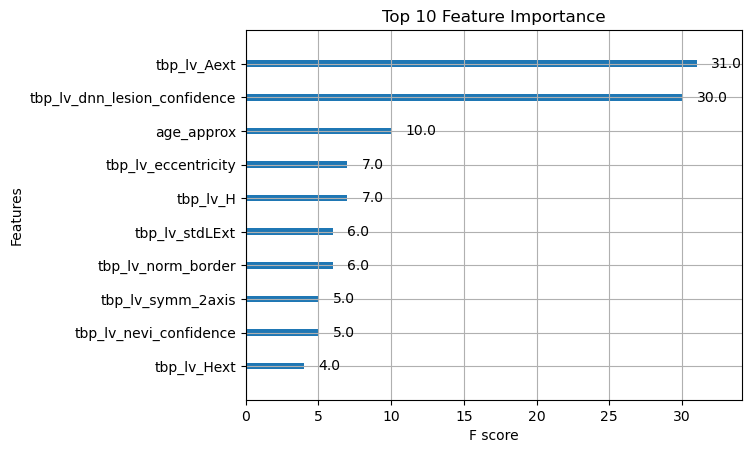

In [57]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance visualization
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importance")
plt.show()
